# Import Libraries

In [ ]:
import cv2 as cv
from google.colab.patches import cv_imshow
import numpy as np

# Open Image

In [ ]:
image = cv.imread('Handwritten arabic text for testing.jpg')

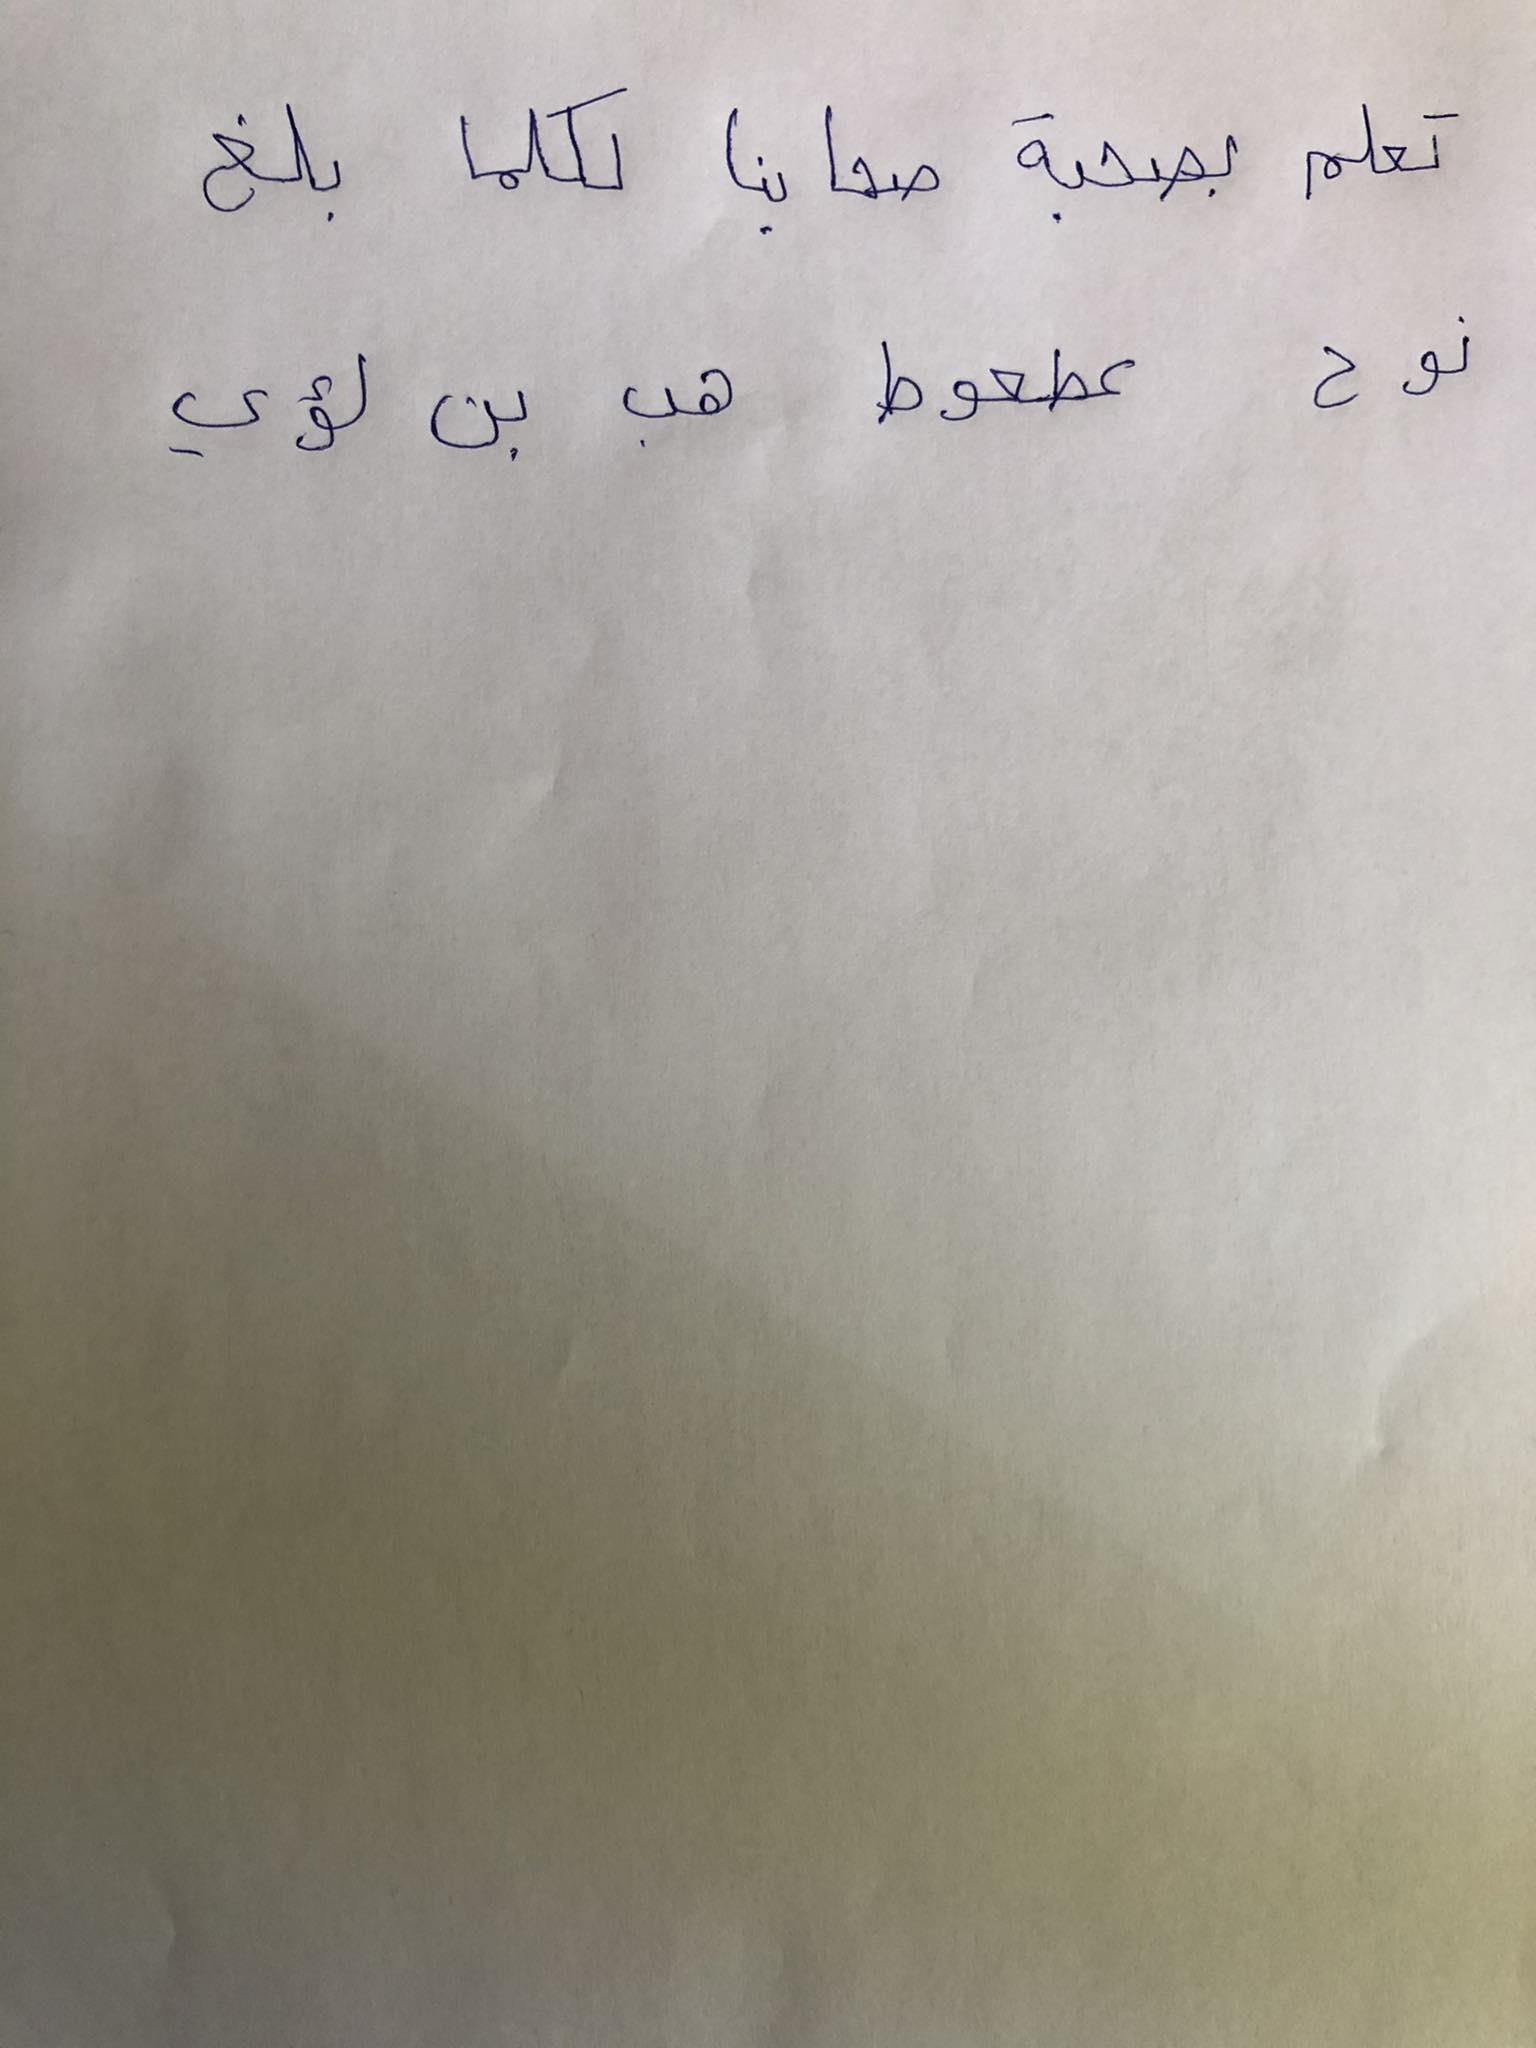

In [ ]:
cv_imshow(image)

# Resize Image

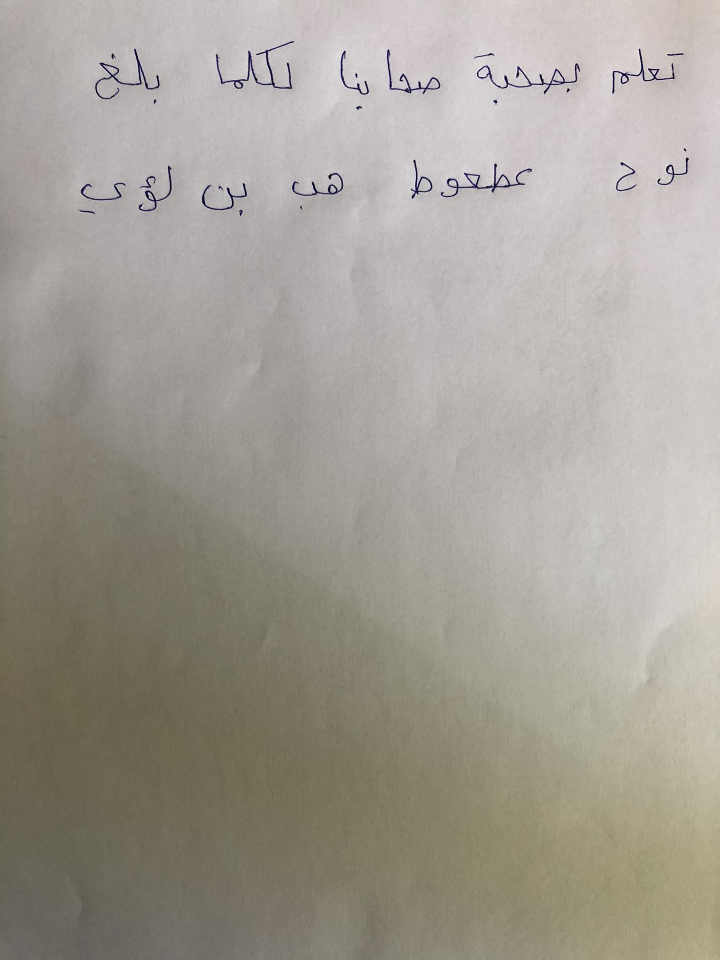

In [17]:
h, w, c = image.shape #height width what's c? Color channels



new_w = 720
ar = w/h #aspect ratio
new_h = int(new_w/ar)


image = cv.resize(image ,(new_w,new_h), interpolation = cv.INTER_CUBIC)

cv_imshow(image)

# Blur Image

In [ ]:
blurredImage = cv.bilateralFilter(image, 101,30,30)

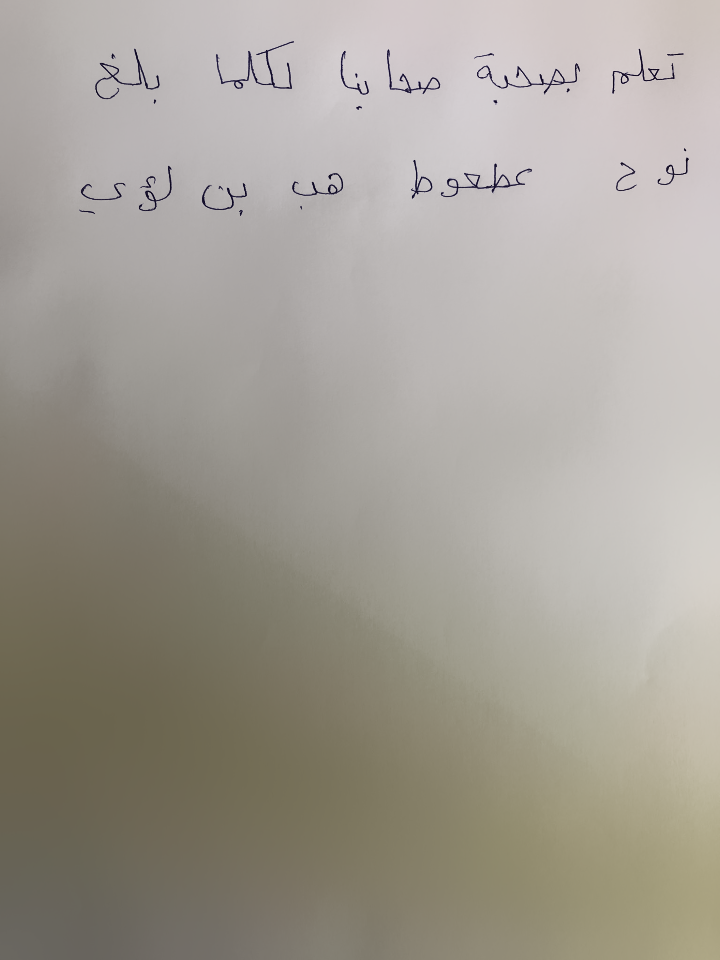

In [ ]:
cv_imshow(blurredImage)

# Binarization Image

In [9]:
grayImage = cv.cvtColor(blurredImage, cv.COLOR_BGR2GRAY)

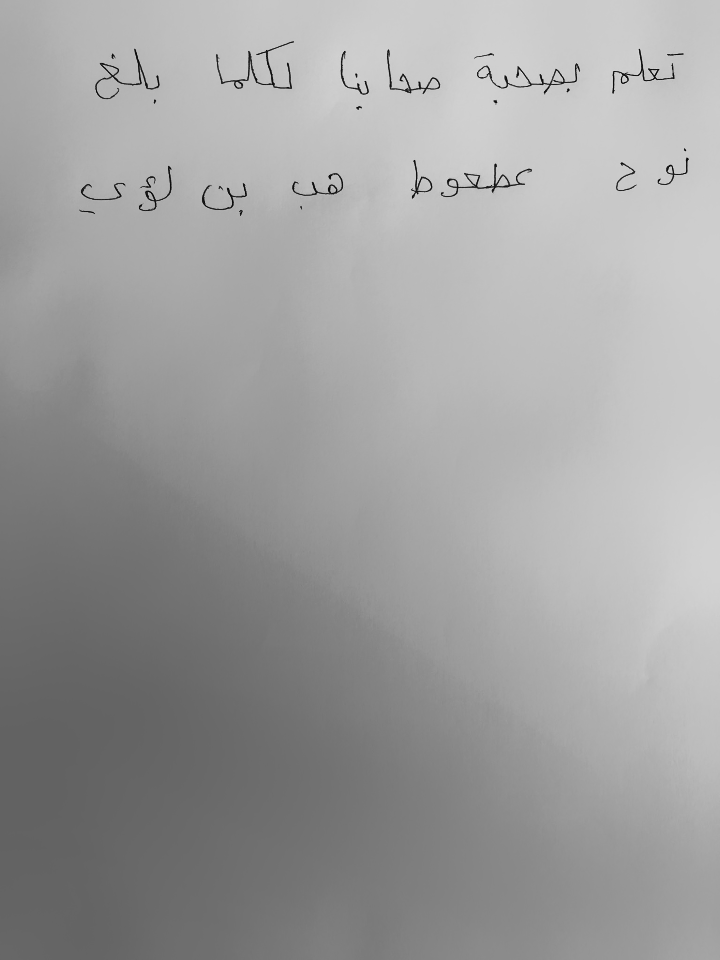

In [10]:
cv_imshow(grayImage)

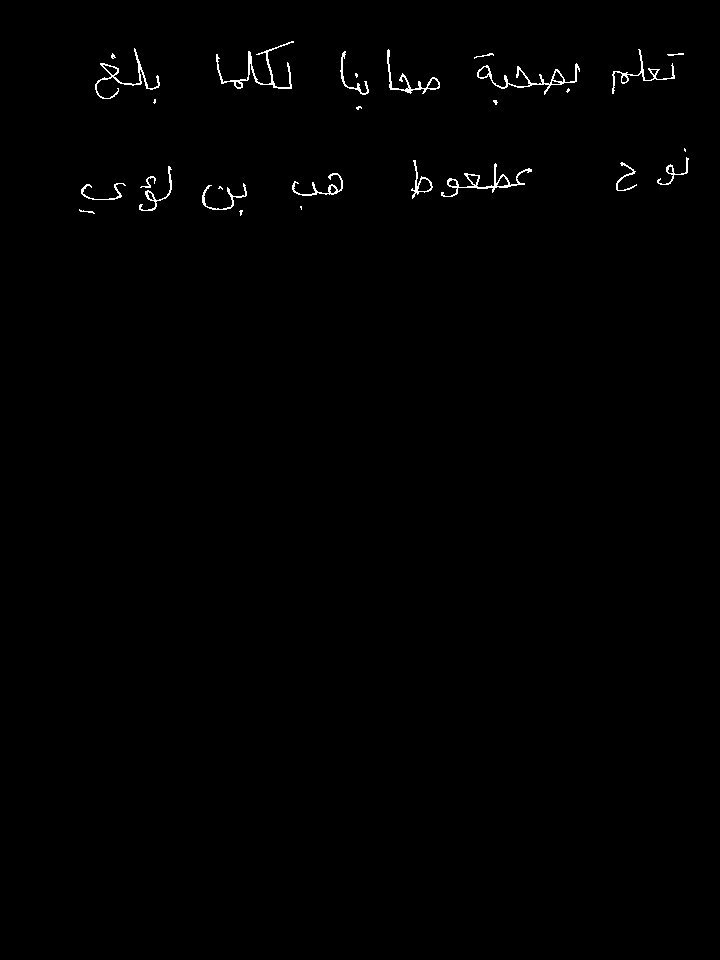

In [11]:
binarizedImage = cv.adaptiveThreshold(grayImage,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY_INV, 17, 20)
cv_imshow(binarizedImage)

# Dilation Segmenting

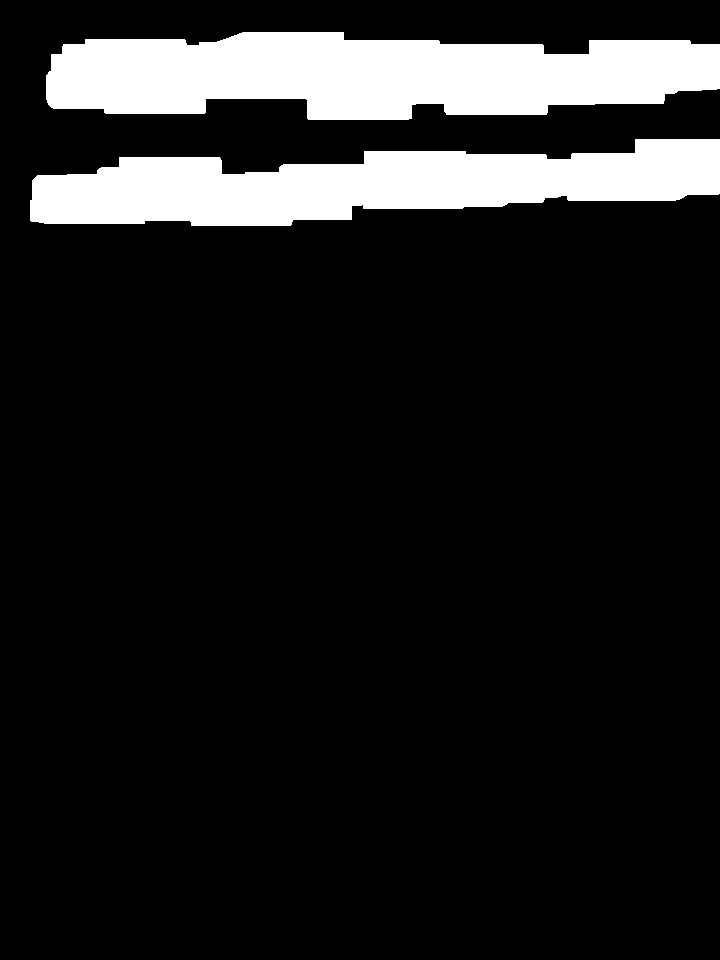

In [12]:
kernel = np.ones((20,100), np.uint8) #The number might need to be changed
dialated = cv.dilate(binarizedImage,kernel,iterations= 1)
cv_imshow(dialated)

In [13]:
(contours,hierarchy) = cv.findContours(dialated.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
#RETR_EXTERNAL means there are no contours within contours
sorted_contours_lines = contours

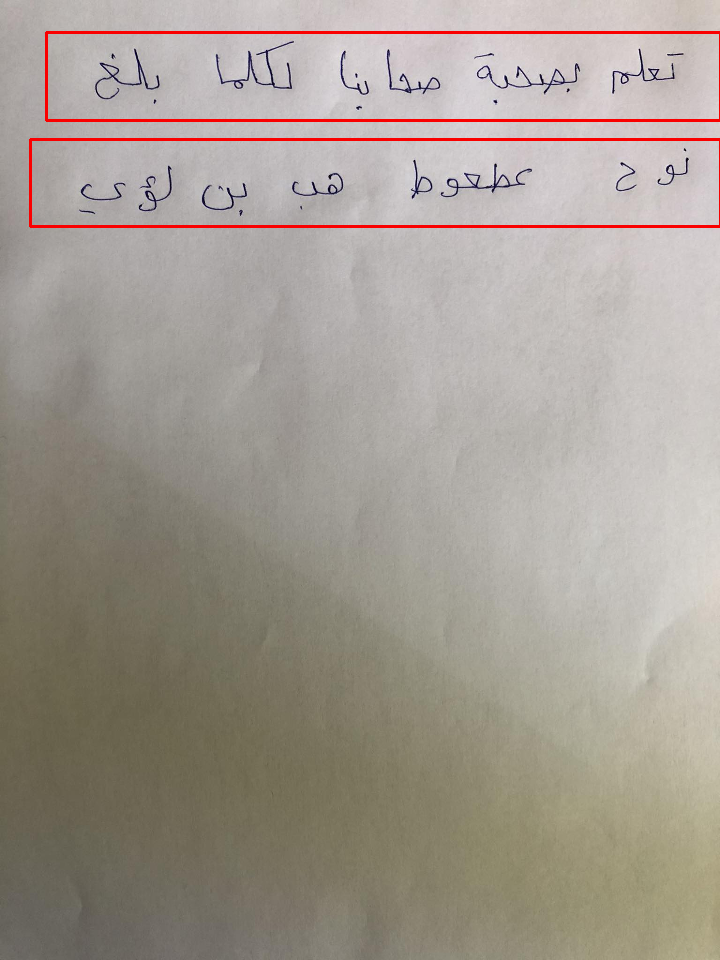

In [14]:
lineSegmented = image.copy()

for ctr in sorted_contours_lines:

  if cv.contourArea(ctr) < 1000: #removes noise but can be adjusted
      continue
  x,y,w,h = cv.boundingRect(ctr)
  cv.rectangle(lineSegmented,(x,y),(x+w,y+h),(0,0,250),2)

cv_imshow(lineSegmented)

## Word Segmentation

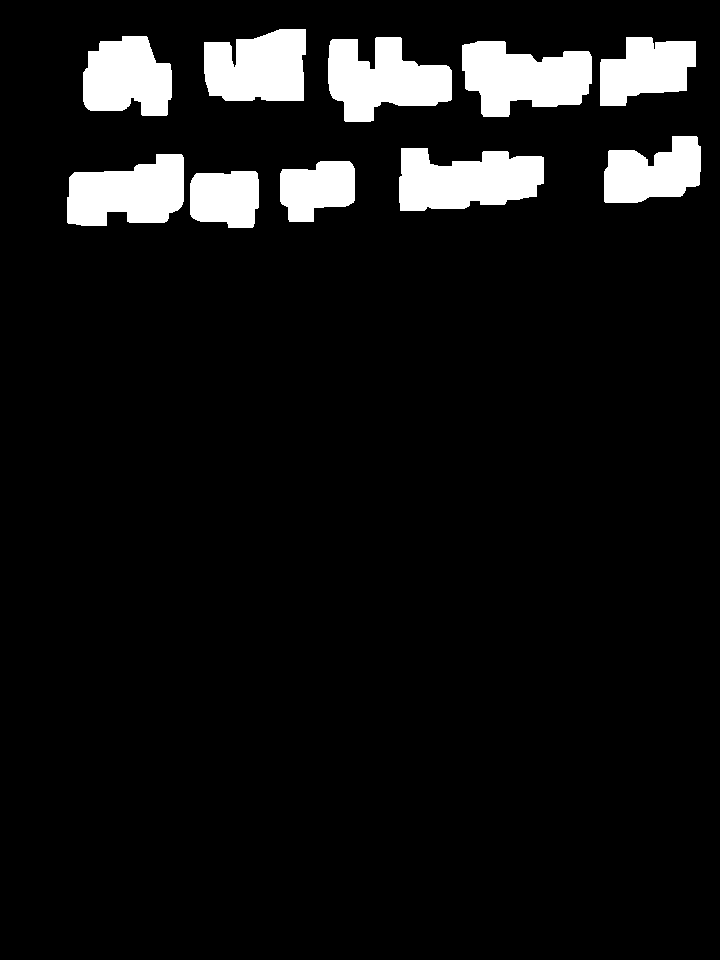

In [15]:
kernel = np.ones((25,25), np.uint8) #The number might need to be changed
dialated2 = cv.dilate(binarizedImage,kernel,iterations= 1)
cv_imshow(dialated2)

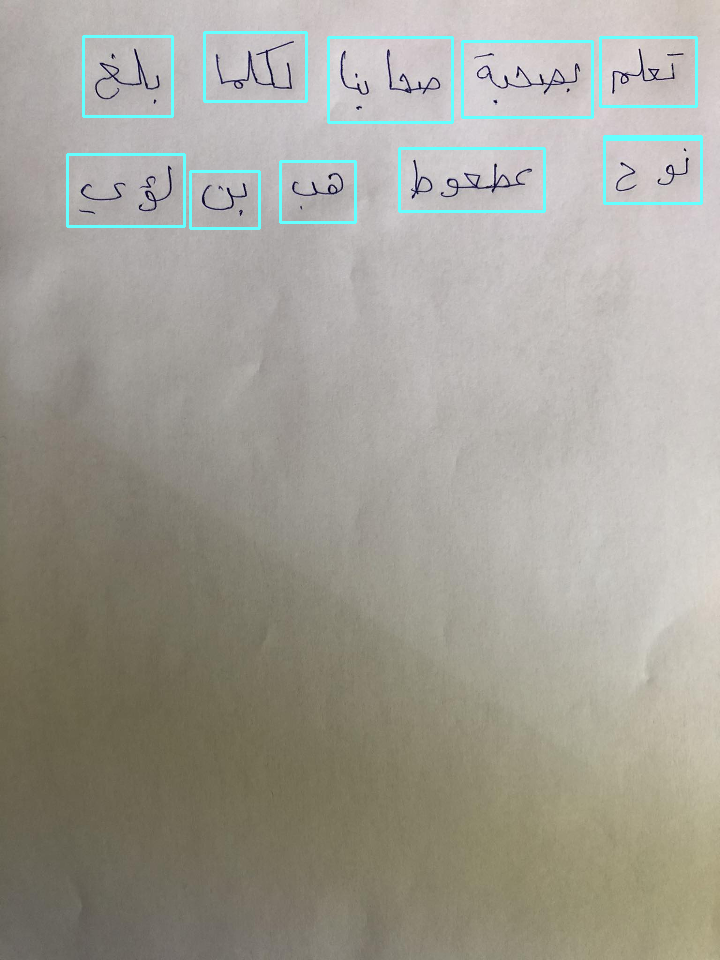

In [16]:
img3 = image.copy()
words_list = []

for line in sorted_contours_lines:
  if cv.contourArea(line) < 1000: #removes noise but can be adjusted
      continue
  x,y,w,h = cv.boundingRect(line)
  roi_line = dialated2[y:y+w, x:x+w]
  #cv_imshow(roi_line)

  #Draw contours on each word
  (cnt,hierarchy) = cv.findContours(roi_line.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
  #RETR_EXTERNAL means there are no contours within contours
  sorted_contours_words = sorted(cnt, key = lambda cntr: cv.boundingRect(cntr)[0], reverse=True) #Contains (x,y,w,h) x and y locations and width and height

  for word in sorted_contours_words:

    if cv.contourArea(word) < 600: #removes noise
      continue
    x2,y2,w2,h2 = cv.boundingRect(word)
    words_list.append([x+x2,y+y2,x+x2+w2,y+y2+h2])
    #print([x+x2,y+y2,x+x2+w2,y+y2+h2])
    cv.rectangle(img3,(x+x2,y+y2),(x+x2+w2,y+y2+h2),(255,255,100),2)
    #cv_imshow(img3)


cv_imshow(img3)

### Store each words from top to bottom and right to left.

In [ ]:
words_list = []

for ctr in sorted_contours_lines[::-1]:

  if cv.contourArea(ctr) < 1000: #removes noise but can be adjusted
      continue
  x,y,w,h = cv.boundingRect(ctr)
  line = dialated2 [y:y+h,x:x+w]

  (cnt,hierarchy) = cv.findContours(line.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)

  sorted_contours_words = sorted(cnt, key = lambda cntr: cv.boundingRect(cntr)[0], reverse=True)

  for word in sorted_contours_words:

    if cv.contourArea(word) < 600: #removes noise
      continue
    x2,y2,w2,h2 = cv.boundingRect(word)
    words_list.append([x+x2,y+y2,x+x2+w2,y+y2+h2])




# Store each word separtely

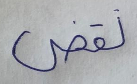

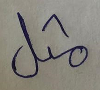

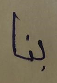

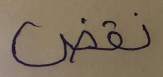

In [ ]:
words=[]

for word in words_list:
  word = image[ word[1]:word[3], word[0]:word[2]]
  words.append(word)
  cv_imshow(word)

# Resize all of the words

In [ ]:
def resizeImage(word):

  word = cv.resize(word,(64,32),interpolation=cv.INTER_CUBIC)

  return word

In [ ]:
resized_words = [ resizeImage(word) for word in words]

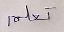

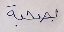

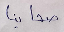

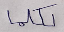

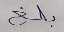

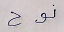

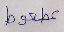

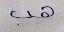

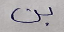

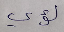

In [ ]:
for word in resized_words:
  cv_imshow(word)

# Binarize the words

In [ ]:
def convertToGray(image):

  image = cv.cvtColor(image,cv.COLOR_BGR2GRAY)

  return image

In [ ]:
gray_words = [ convertToGray(word) for word in words]

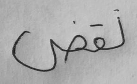

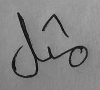

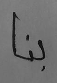

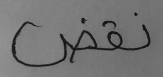

In [ ]:
for word in gray_words:
  cv_imshow(word)

In [ ]:
def binarizeWords(image):
  image = cv.adaptiveThreshold(image,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY_INV,17, 15)

  return image

In [ ]:
binary_words = [ binarizeWords(word) for word in gray_words]

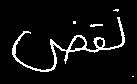

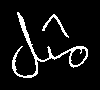

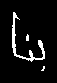

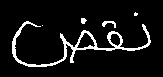

In [ ]:
for word in binary_words:
  cv_imshow(word)

# Testing out the preprocessing

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras

In [ ]:
import numpy as np
model = tf.keras.models.load_model('currBest_may_28_2024.h5')
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 64, 32, 1)]       0         
                                                                 
 Conv1 (Conv2D)              (None, 64, 32, 32)        320       
                                                                 
 pool1 (MaxPooling2D)        (None, 32, 16, 32)        0         
                                                                 
 batch_normalization_25 (Ba  (None, 32, 16, 32)        128       
 tchNormalization)                                               
                                                                 
 Conv2 (Conv2D)              (None, 32, 16, 64)        18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 16, 8, 64)         0         
                                                           

# Another pre processing method

In [ ]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image


In [ ]:
def decode_batch_predictions(pred):
    max_len=7
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=False)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    #print(results)
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("UTF-8")
        output_text.append(res)

    return output_text

In [ ]:
characters = {'ن', 'س', 'ة', 'ك', '.', 'ء', '،', 'ف', 'ه', 'ب', 'خ', 'ؤ', 'غ', 'ز', 'ق', 'ث', 'ح', 'ذ', 'ئ', 'آ', 'إ', 'ض', 'ش', 'م', 'ر', 'ص', 'ا', 'ٍ', ':', 'و', 'أ', 'ظ', 'ل', 'ج', 'د', 'ع', 'ط', 'ت', 'ي'}


char_to_num = StringLookup(vocabulary=list(sorted(characters)), mask_token=None)


num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
image_width = 64
image_height = 32

def preprocess_image2(image, img_size=(image_width, image_height)):
    image = tf.image.decode_jpeg(image, 1)

    image = distortion_free_resize(image, img_size)

    image =  tf.where(image > 80, 255, 0)#Basic thresholding

    image = tf.cast(image, tf.float32) / 255.0

    return image

In [ ]:
pred=""

for i in range(len(binary_words)):
  test = cv.imencode('.jpg',binary_words[i])[1]
  image = preprocess_image2(test.tobytes())
  preds = model.predict(np.array([image]))
  pred_texts = decode_batch_predictions(preds)
  pred+="".join(pred_texts)+" "

pred

1/1 [==============================] - 0s 33ms/step


'لزمت قواف بنا لقغست '

In [ ]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 64, 32, 1)]       0         
                                                                 
 Conv1 (Conv2D)              (None, 64, 32, 32)        320       
                                                                 
 pool1 (MaxPooling2D)        (None, 32, 16, 32)        0         
                                                                 
 batch_normalization_25 (Ba  (None, 32, 16, 32)        128       
 tchNormalization)                                               
                                                                 
 Conv2 (Conv2D)              (None, 32, 16, 64)        18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 16, 8, 64)         0         
                                                           